In [ ]:
# Basic
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import csv
import pickle

# SpikeInterface
import spikeinterface.full as si
import spikeinterface.extractors as se
from spikeinterface.preprocessing import get_motion_parameters_preset, get_motion_presets

# Local imports
import libs.utils.utils as utils
import libs.handle.dataset as handle_dataset
import libs.analysis.spikes as spikes


c:\Users\Sugimoto\Code\tc2025_shysgmt\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_behv_time(trials, event, procTeensy_to_imec):
    """
    Compute the time of stimulus, choice, and outcome for each trial.
    
    Parameters:
    trials (pd.DataFrame): DataFrame containing trial information.
    event (pd.DataFrame): DataFrame containing event information.
    procTeensy_to_imec (np.ndarray): Array mapping Teensy times to imec times.
    
    Returns:
    stim_time (np.ndarray): Array of stimulus times for each trial.
    choice_time (np.ndarray): Array of choice times for each trial.
    outcome_time (np.ndarray): Array of outcome times for each trial.
    """
    event_grouped = event.groupby('Trial')
    target_trials = trials['Trial'].dropna().astype(int).values

    stim_time = np.zeros(len(target_trials))
    choice_time = np.zeros(len(target_trials))
    outcome_time = np.zeros(len(target_trials))


    for i in range(0, len(target_trials)):

        df = event_grouped.get_group(target_trials[i])
        
        tf = (df['State'].isin([3, 4])) & (df['Column_name_changed'].isin(['Binary_photodiode']))
        row = df[tf]['Row_index'].values
        stim_time[i] = procTeensy_to_imec[row[0]]

        tf = (df['State'].isin([5, 6, 7, 8])) & (df['State'].shift(1).isin([3, 4]))
        row = df[tf]['Row_index'].values
        choice_time[i] = procTeensy_to_imec[row[0]]
        
        
        tf = df['Column_name_changed'].isin(['Dispenser'])&(df['Dispenser'] == 1)
        if tf.any():
            row = df[tf]['Row_index'].values
            outcome_time[i] = procTeensy_to_imec[row[0]]
        else:
            outcome_time[i] = np.nan
        
    # 
    behvior_time ={
        'stim': stim_time,
        'choice': choice_time,
        'outcome': outcome_time
    }
        
    return behvior_time

In [3]:
session_dir = r'Z:\Data\RSS033\RSS033_241101_153102'
session = handle_dataset.Session(session_dir)

In [4]:
i_imec = 0
session.add_analyzer_clean(i_imec=i_imec)
session.add_procTeensy_to_imec(i_imec=i_imec)
session.add_event()

In [5]:
sorting = session.analyzer_clean.sorting

In [6]:
unit_ids = sorting.get_unit_ids()
event = session.event
trials = session.trials
procTeensy_to_imec = session.procTeensy_to_imec
sampling_rate = sorting.sampling_frequency

In [7]:
behv_time = compute_behv_time(trials, event, procTeensy_to_imec) 

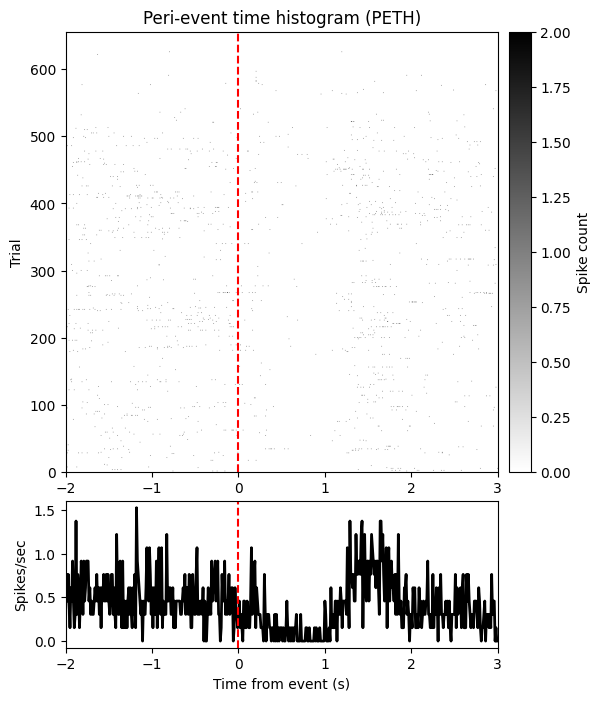

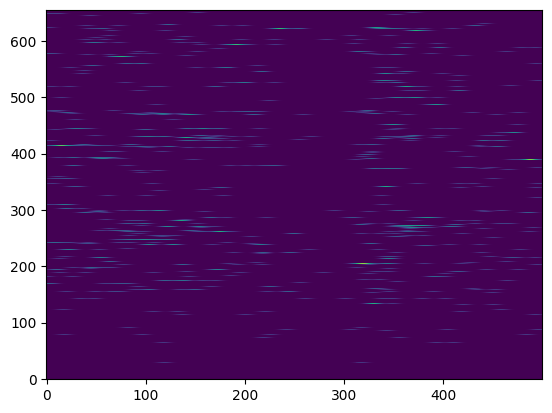

In [8]:
unit_id = unit_ids[5]
event_time = behv_time['outcome']
spike_time = sorting.get_unit_spike_train(unit_id=unit_id)/sampling_rate

peth = spikes.compute_peth_array(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.01,
    time_window=[-2, 3],
    plot=True)


peth = spikes.compute_peth_smooth(peth, sigma_sec=0.05)
plt.imshow(
    peth['spike_density'],
    aspect='auto',
    origin='lower',
    cmap='viridis',
    interpolation='nearest'
)


<Axes: xlabel='Time', ylabel='Spike_rate'>

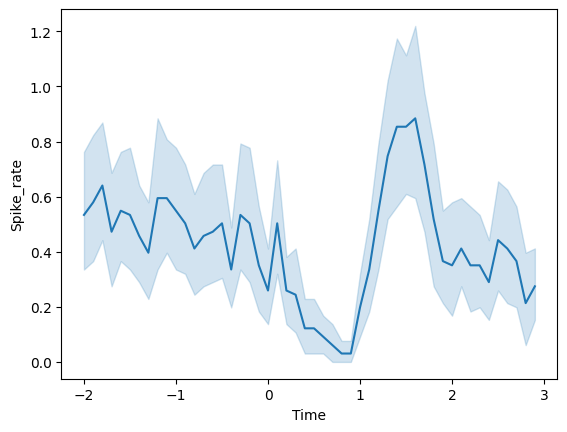

In [9]:
peth = spikes.compute_peth_df(
    spike_times=spike_time,
    event_times=event_time,
    bin_size=0.1,
    time_window=[-2, 3],
    plot=False)

sns.lineplot(
    x=peth['Time'],
    y=peth['Spike_rate'],
    estimator='mean',
)